<a href="https://colab.research.google.com/github/prabjotbali/Disease-Detection-YOLOv5/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!get_ipython().system('pip install tensorflow')
!get_ipython().system('pip install basic_image_eda')

/bin/bash: -c: line 0: syntax error near unexpected token `.system'
/bin/bash: -c: line 0: `get_ipython().system('pip install tensorflow')'
/bin/bash: -c: line 0: syntax error near unexpected token `.system'
/bin/bash: -c: line 0: `get_ipython().system('pip install basic_image_eda')'


In [ ]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
sns.set_theme(style="whitegrid")
import cv2
import sys
from re import sub
import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
data_dir = r"/content/drive/MyDrive/Apple"

In [ ]:
img = plt.imread(data_dir+"/Unhealthy_Apple/100.jpg")
plt.imshow(img)

FileNotFoundError: ignored

In [ ]:
category_count = []
for root, dirs, files in os.walk(data_dir):
    for dir_path in dirs:
        category_count.append((dir_path, len(os.listdir(root+os.sep+dir_path))))
count_df = pd.DataFrame(category_count, columns=['Category', 'Count'])
count_df.head(10)

,Category,Count
0,Healthy_Apple,245
1,Unhealthy_Apple,275


In [ ]:
total_images = count_df['Count'].sum()
total_images  

520

[]

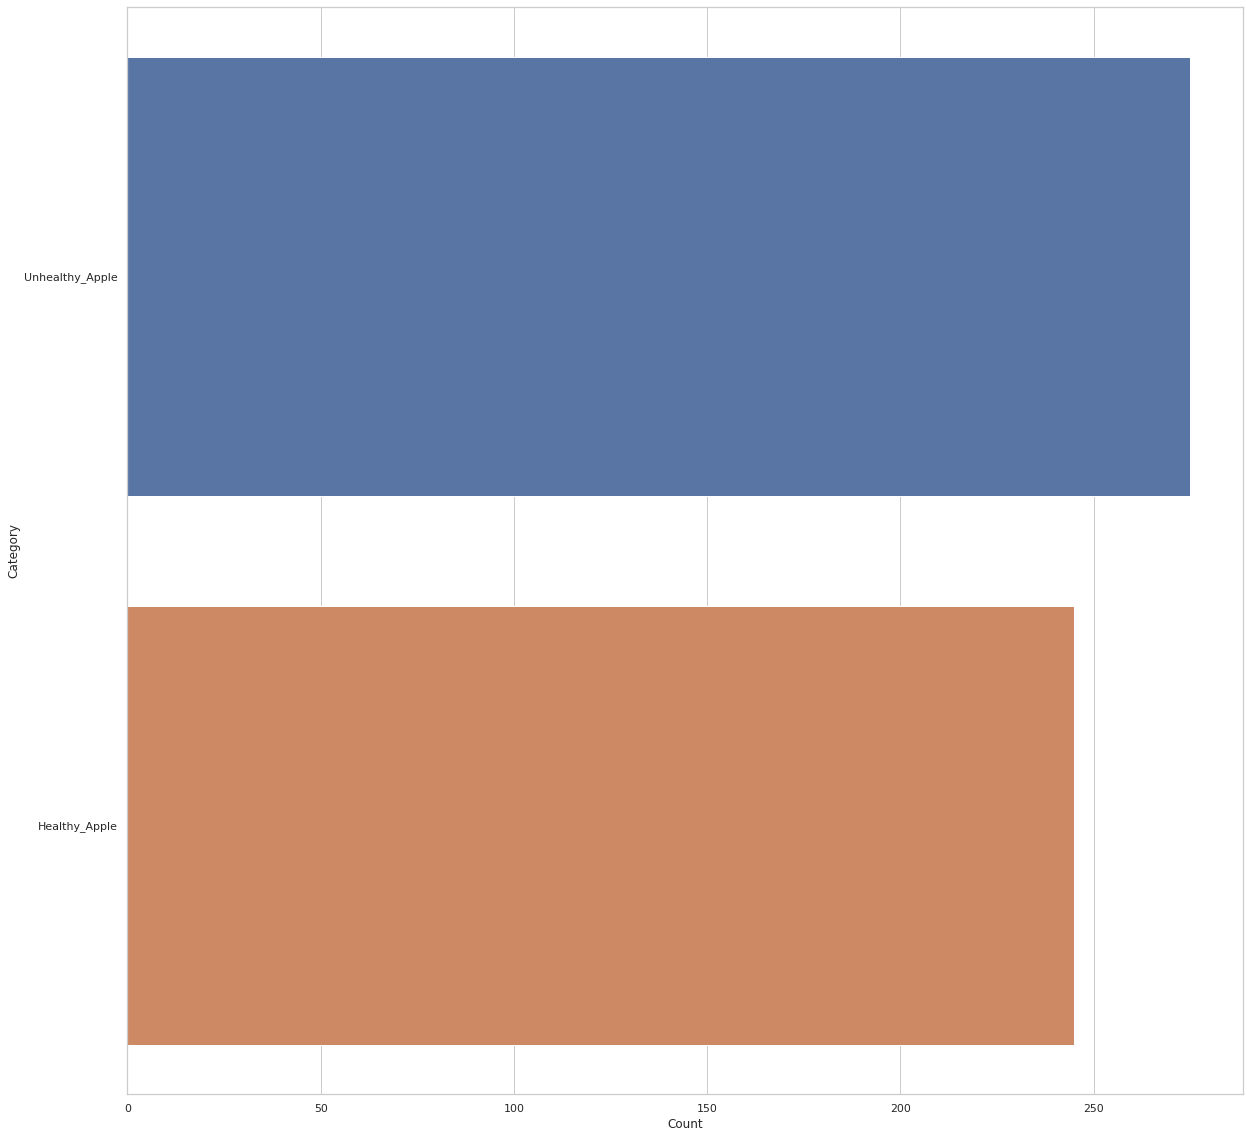

In [ ]:
count_df = count_df.sort_values(by='Count', ascending=False)
plt.figure(figsize=(20,20))
sns.barplot(x="Count", y="Category", data=count_df)
plt.plot()

In [ ]:
healthy_images_count = count_df[count_df['Category'].str.endswith("Healthy_Apple")]['Count'].sum()
healthy_images_count

245

In [ ]:
disease_images_count = total_images - healthy_images_count
disease_images_count

275

[]

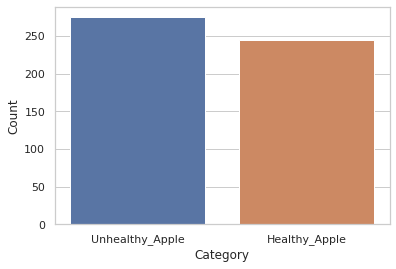

In [ ]:
temp_df = pd.DataFrame(data=[("Unhealthy_Apple", disease_images_count), ("Healthy_Apple", healthy_images_count)], columns=['Category', 'Count'])
sns.barplot(y="Count",x="Category", data=temp_df)
plt.plot()

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (320,320)

train_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.2,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "training",
                                             image_size=IMG_SIZE)

Found 520 files belonging to 2 classes.
Using 416 files for training.


In [ ]:
validation_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.2,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "validation",
                                             image_size=IMG_SIZE)

Found 520 files belonging to 2 classes.
Using 104 files for validation.


In [ ]:
class_names = train_dataset.class_names
num_classes = len(class_names)
for i in range(1, num_classes + 1):
    print(str(i) + ". ", class_names[i - 1])

1.  Healthy_Apple
2.  Unhealthy_Apple


In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 4
Number of test batches: 0


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

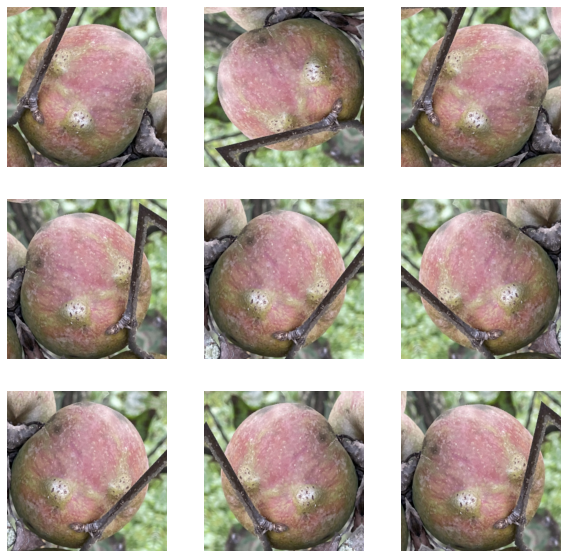

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
def plot_metrics(history):
  colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
  metrics = ['loss', 'auc', 'precision', 'recall']
  plt.figure(figsize=(20,10))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [ ]:
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.CategoricalAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc')
]

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input

base_model = tf.keras.applications.InceptionResNetV2(
                                include_top=False,
                                weights="imagenet",
                                input_shape=IMG_SHAPE,
                            )

219055592/219055592 [==============================] - 12s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 1536)


In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average.shape)

(32, 1536)


In [ ]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


In [ ]:
inputs = tf.keras.Input(shape=(320, 320, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=METRICS)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 320, 320, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 320, 320, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 320, 320, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 320, 320, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                             

In [ ]:
initial_epochs = 50

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/50


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5534: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


13/13 [==============================] - 88s 6s/step - loss: 0.7437 - tp: 216.0000 - fp: 200.0000 - tn: 216.0000 - fn: 200.0000 - accuracy: 0.5192 - precision: 0.5192 - recall: 0.5192 - auc: 0.5317 - val_loss: 0.6724 - val_tp: 62.0000 - val_fp: 42.0000 - val_tn: 62.0000 - val_fn: 42.0000 - val_accuracy: 0.5962 - val_precision: 0.5962 - val_recall: 0.5962 - val_auc: 0.6232
Epoch 2/50
13/13 [==============================] - 11s 632ms/step - loss: 0.6682 - tp: 252.0000 - fp: 164.0000 - tn: 252.0000 - fn: 164.0000 - accuracy: 0.6058 - precision: 0.6058 - recall: 0.6058 - auc: 0.6386 - val_loss: 0.6693 - val_tp: 61.0000 - val_fp: 43.0000 - val_tn: 61.0000 - val_fn: 43.0000 - val_accuracy: 0.5865 - val_precision: 0.5865 - val_recall: 0.5865 - val_auc: 0.6340
Epoch 3/50
13/13 [==============================] - 11s 717ms/step - loss: 0.6475 - tp: 270.0000 - fp: 146.0000 - tn: 270.0000 - fn: 146.0000 - accuracy: 0.6490 - precision: 0.6490 - recall: 0.6490 - auc: 0.6848 - val_loss: 0.6679 - val

In [ ]:
base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 700
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  780


In [ ]:
fine_tuning_learning_rate = 1e-5
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tuning_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=METRICS)


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 320, 320, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 320, 320, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 320, 320, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 320, 320, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                             

In [ ]:
len(model.trainable_variables)

52

In [ ]:
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 50/100


13/13 [==============================] - 37s 969ms/step - loss: 0.4543 - tp: 398.0000 - fp: 122.0000 - tn: 398.0000 - fn: 122.0000 - accuracy: 0.7654 - precision: 0.7654 - recall: 0.7654 - auc: 0.8381 - val_loss: 0.6849 - val_tp: 65.0000 - val_fp: 39.0000 - val_tn: 65.0000 - val_fn: 39.0000 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 0.6250 - val_auc: 0.6942
Epoch 51/100
13/13 [==============================] - 12s 748ms/step - loss: 0.4488 - tp: 333.0000 - fp: 83.0000 - tn: 333.0000 - fn: 83.0000 - accuracy: 0.8005 - precision: 0.8005 - recall: 0.8005 - auc: 0.8738 - val_loss: 0.6939 - val_tp: 68.0000 - val_fp: 36.0000 - val_tn: 68.0000 - val_fn: 36.0000 - val_accuracy: 0.6538 - val_precision: 0.6538 - val_recall: 0.6538 - val_auc: 0.6998
Epoch 52/100
13/13 [==============================] - 11s 716ms/step - loss: 0.4275 - tp: 340.0000 - fp: 76.0000 - tn: 340.0000 - fn: 76.0000 - accuracy: 0.8173 - precision: 0.8173 - recall: 0.8173 - auc: 0.8873 - val_loss: 0.7044 - 

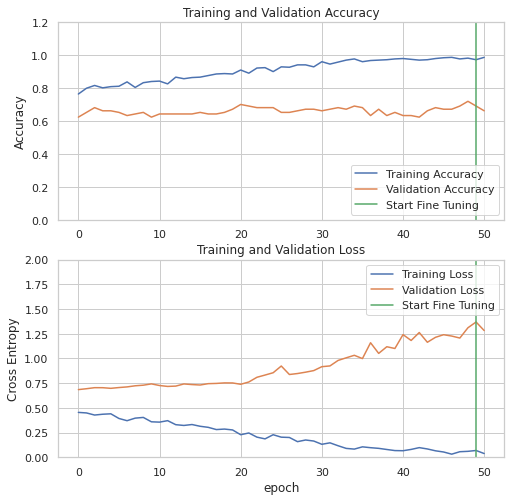

In [ ]:
acc = []          
val_acc = []
loss = []     
val_loss = []

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']



plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1.2])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.show()

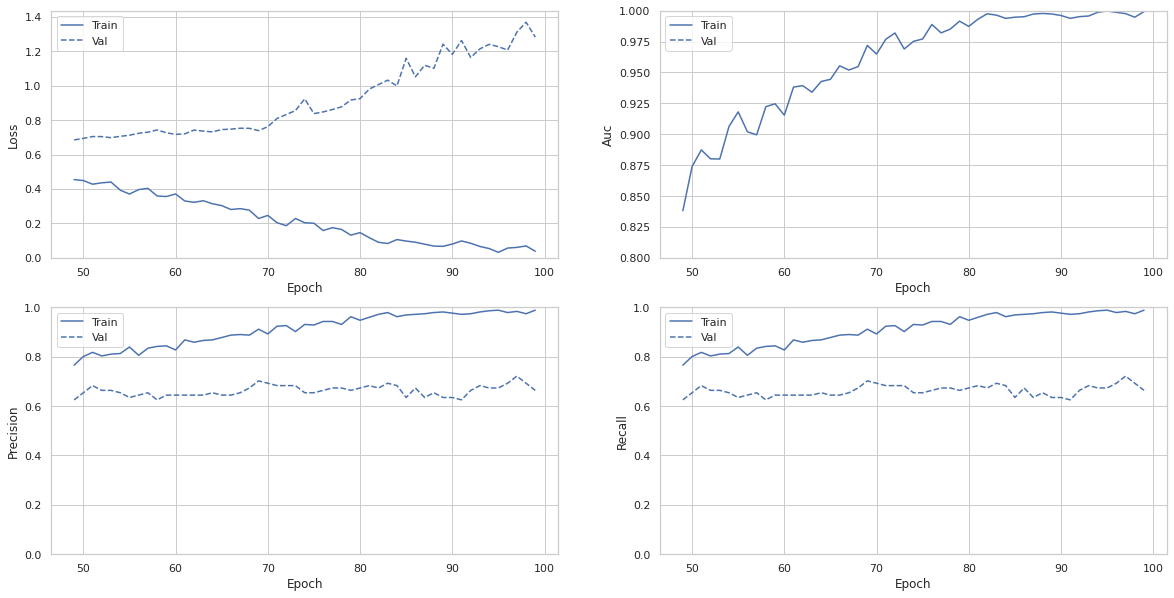

In [ ]:
plot_metrics(history_fine)

In [ ]:
predictions = model.predict_on_batch(image_batch)

predictions = tf.nn.softmax(predictions)
predictions = list(np.argmax(x) for x in predictions.numpy())

In [ ]:
print('Predictions:\n', predictions)
print('Labels:\n', list(np.argmax(x) for x in label_batch))

Predictions:
 [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1]
Labels:
 [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1]


In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

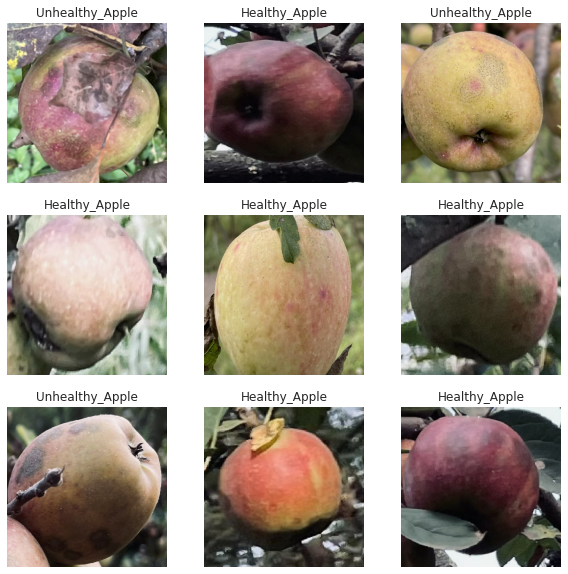

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
import joblib

In [ ]:
joblib.dump(model,"/content/drive/MyDrive/Saved Model/Classification_joblib.pkl")

NameError: ignored

In [ ]:
classification = joblib.load('/content/drive/MyDrive/Saved Model/Classification_joblib.pkl')

/usr/local/lib/python3.9/dist-packages/keras/layers/core/lambda_layer.py:325: UserWarning: keras.applications.inception_resnet_v2 is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


ValueError: ignored

In [ ]:
model_json = model.to_json()
json_file = open("model_weights.json", "w")
json_file.write(model_json)
print("Model saved in JSON format!")
    

model.save_weights("model_weights.h5")
print("\nModel weights saved!")

Model saved in JSON format!

Model weights saved!


In [ ]:
model.save("inception_V3.0_fineTuning.h5")

NameError: ignored

FileNotFoundError: ignored